<a href="https://colab.research.google.com/github/prp20/tensorflow_learning/blob/main/Google_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download -d varpit94/google-stock-data

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 53.1MB/s]


In [4]:
!unzip /content/google-stock-data.zip -d google-stock

Archive:  /content/google-stock-data.zip
  inflating: google-stock/GOOGL.csv  


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
dataset = pd.read_csv('/content/google-stock/GOOGL.csv', parse_dates=["Date"], index_col=["Date"])

In [7]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4431 entries, 2004-08-19 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4431 non-null   float64
 1   High       4431 non-null   float64
 2   Low        4431 non-null   float64
 3   Close      4431 non-null   float64
 4   Adj Close  4431 non-null   float64
 5   Volume     4431 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 242.3 KB


In [9]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4431.000000,4431.000000,4431.000000,4431.000000,4431.000000,4.431000e+03
mean,693.087345,699.735595,686.078751,693.097367,693.097367,6.444992e+06
std,645.118799,651.331215,638.579488,645.187806,645.187806,7.690351e+06
min,49.644646,50.920921,48.028027,50.055054,50.055054,4.656000e+05
25%,248.558563,250.853355,245.813309,248.415916,248.415916,1.695600e+06
50%,434.924927,437.887878,432.687683,435.330322,435.330322,3.778418e+06
75%,1007.364990,1020.649994,997.274994,1007.790008,1007.790008,8.002390e+06
max,3025.000000,3030.929932,2977.979980,2996.770020,2996.770020,8.215117e+07


In [10]:
dataset.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [11]:
google_stock_data = pd.DataFrame(dataset['Close']).rename(columns={'Close':'price'})
google_stock_data.head(10)


,price
Date,
2004-08-19,50.220219
2004-08-20,54.209209
2004-08-23,54.754753
2004-08-24,52.487488
2004-08-25,53.053055
2004-08-26,54.009010
2004-08-27,53.128128
2004-08-30,51.056057
2004-08-31,51.236237


In [12]:
google_stock_data.tail()

,price
Date,
2022-03-18,2722.510010
2022-03-21,2722.030029
2022-03-22,2797.360107
2022-03-23,2765.510010
2022-03-24,2831.439941


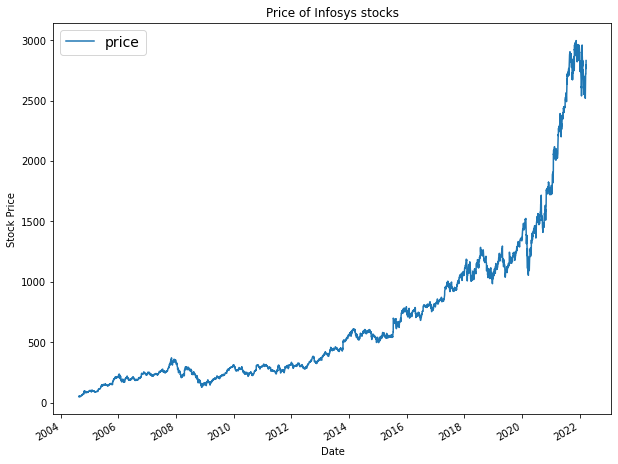

In [13]:
google_stock_data.plot(figsize=(10,8))
plt.ylabel("Stock Price")
plt.title("Price of Infosys stocks")
plt.legend(fontsize=14)

In [14]:
timesteps = google_stock_data.index.to_numpy()
prices = google_stock_data["price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2004-08-19T00:00:00.000000000', '2004-08-20T00:00:00.000000000',
        '2004-08-23T00:00:00.000000000', '2004-08-24T00:00:00.000000000',
        '2004-08-25T00:00:00.000000000', '2004-08-26T00:00:00.000000000',
        '2004-08-27T00:00:00.000000000', '2004-08-30T00:00:00.000000000',
        '2004-08-31T00:00:00.000000000', '2004-09-01T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([50.220219, 54.209209, 54.754753, 52.487488, 53.053055, 54.00901 ,
        53.128128, 51.056057, 51.236237, 50.175175]))

In [15]:
split_size = int(0.8 * len(prices))
split_size

3544

In [16]:
X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test)

(3544, 887)

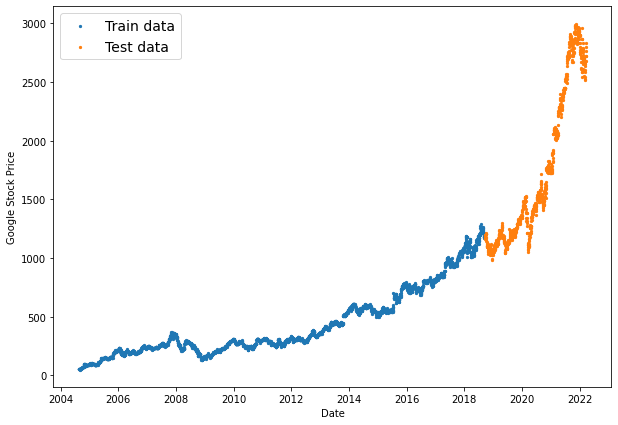

In [17]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Google Stock Price")
plt.legend(fontsize=14)
plt.show();

In [18]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

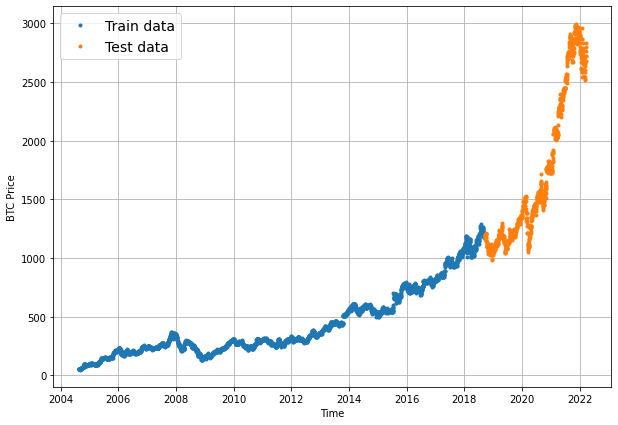

In [19]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

# Model 0: Naive Forcast

In [20]:
naive_forecast=y_test[:-1]

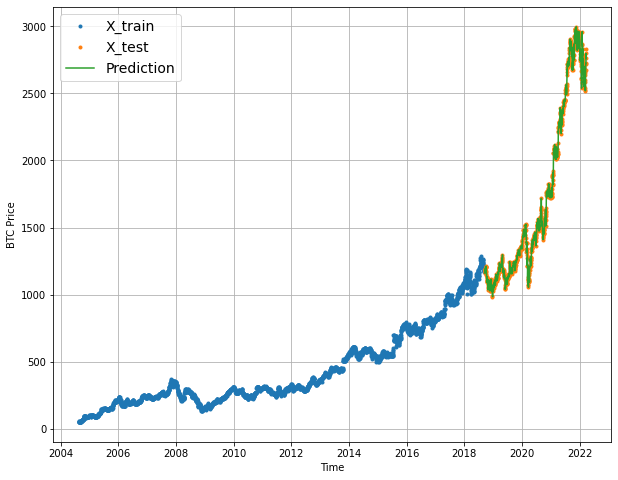

In [21]:
plt.figure(figsize=(10,8))
plot_time_series(timesteps=X_train, values=y_train, label="X_train")
plot_time_series(timesteps=X_test, values=y_test, label="X_test")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, format="-", label="Prediction")

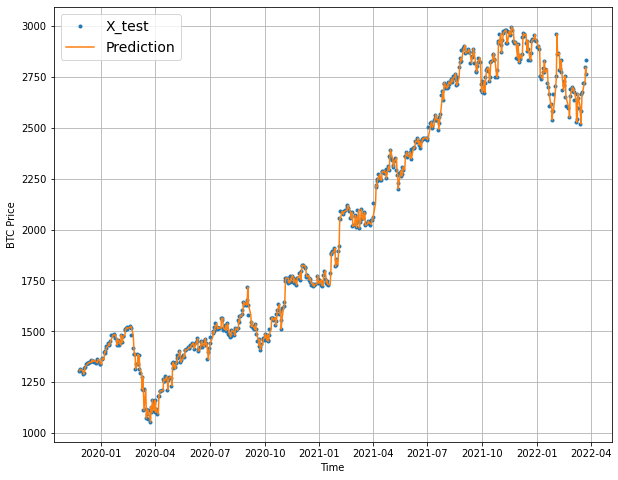

In [22]:
plt.figure(figsize=(10,8))
offset=300
plot_time_series(timesteps=X_test, values=y_test,start=offset, label="X_test")
plot_time_series(timesteps=X_test[1:], values = naive_forecast, start=offset, format="-", label="Prediction")

In [23]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [25]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 22.165747,
 'mse': 1057.8799,
 'rmse': 32.525063,
 'mape': 1.3207381,
 'mase': 0.99924177}

In [26]:
tf.reduce_mean(y_test).numpy()

1730.2109131352875

In [27]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [28]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [29]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [32]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels


In [33]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(4424, 4424)

In [34]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [35]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3539, 885, 3539, 885)

In [36]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [37]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # s

# Model 1: Dense Model(Window=7, horizon=1)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) 

Epoch 1/100
28/28 [==============================] - 1s 21ms/step - loss: 73.7915 - mae: 73.7915 - val_loss: 95.5759 - val_mae: 95.5759
Epoch 2/100
28/28 [==============================] - 0s 18ms/step - loss: 12.0586 - mae: 12.0586 - val_loss: 41.3003 - val_mae: 41.3003
Epoch 3/100
28/28 [==============================] - 0s 17ms/step - loss: 8.7218 - mae: 8.7218 - val_loss: 33.4671 - val_mae: 33.4671
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 8.4094 - mae: 8.4094 - val_loss: 33.5891 - val_mae: 33.5891
Epoch 5/100
28/28 [==============================] - 1s 18ms/step - loss: 8.4313 - mae: 8.4313 - val_loss: 32.7008 - val_mae: 32.7008
Epoch 6/100
28/28 [==============================] - 0s 4ms/step - loss: 8.2476 - mae: 8.2476 - val_loss: 33.1221 - val_mae: 33.1221
Epoch 7/100
28/28 [==============================] - 1s 26ms/step - loss: 8.0797 - mae: 8.0797 - val_loss: 32.1050 - val_mae: 32.1050
Epoch 8/100
28/28 [==============================] - 0s 4ms/

In [46]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 22.9370 - mae: 22.9370


[22.937040328979492, 22.937040328979492]

In [47]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 22.9370 - mae: 22.9370


[22.937040328979492, 22.937040328979492]

In [48]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [49]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

28/28 [==============================] - 0s 1ms/step


(885, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([1168.4681, 1176.2637, 1190.1562, 1182.5453, 1183.8976, 1192.9911,
        1197.1638, 1208.0782, 1212.973 , 1212.329 ], dtype=float32)>)

In [50]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 22.93704,
 'mse': 1107.4034,
 'rmse': 33.27767,
 'mape': 1.3551556,
 'mase': 1.0332205}

In [51]:
naive_results

{'mae': 22.165747,
 'mse': 1057.8799,
 'rmse': 32.525063,
 'mape': 1.3207381,
 'mase': 0.99924177}

# Model 2: Dense (window = 30, horizon = 1)

In [51]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [59]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=30, horizon=1)
len(full_windows), len(full_labels)

(4401, 4401)

In [60]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3520, 881, 3520, 881)

In [61]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [62]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 46.9813


46.98126983642578

In [63]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 26.5520


26.551973342895508

In [64]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

28/28 [==============================] - 0s 1ms/step


In [65]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 26.551968,
 'mse': 1406.7421,
 'rmse': 37.50656,
 'mape': 1.5601889,
 'mase': 1.1942074}

# Model 3: Dense (window = 30, horizon = 7)

In [84]:
full_windows, full_labels = make_windows(prices, window_size=30, horizon=7)
len(full_windows), len(full_labels)

(4395, 4395)

In [85]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3516, 879, 3516, 879)

In [88]:
test_windows.shape, test_labels.shape

((879, 30), (879, 7))

In [90]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(7)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [91]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 49.3709


49.370906829833984

In [92]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 43.0675


43.067481994628906

In [93]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

28/28 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[1165.6654, 1164.5137, 1179.7056, 1182.1954, 1178.3685, 1182.5605,
        1185.8641],
       [1176.4402, 1168.5579, 1181.7761, 1187.154 , 1181.7229, 1181.1512,
        1184.6238],
       [1189.2389, 1178.0712, 1190.1901, 1189.8557, 1197.6742, 1194.9288,
        1188.4236],
       [1183.2014, 1176.9606, 1186.295 , 1194.2166, 1193.2247, 1195.2029,
        1198.7704],
       [1177.3405, 1177.0286, 1180.1763, 1195.9568, 1186.9293, 1187.9536,
        1195.0388]], dtype=float32)>

In [94]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [95]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 43.067482,
 'mse': 3826.5264,
 'rmse': 49.345604,
 'mape': 2.5399802,
 'mase': 1.9445084}

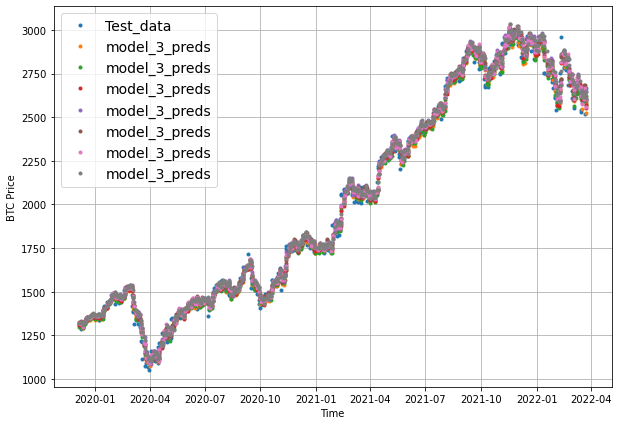

In [96]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

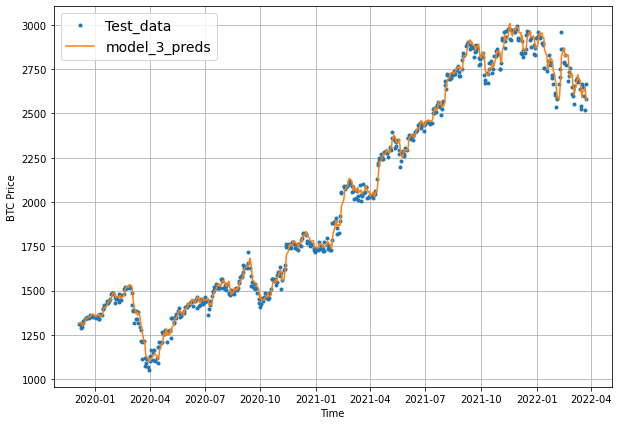

In [97]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

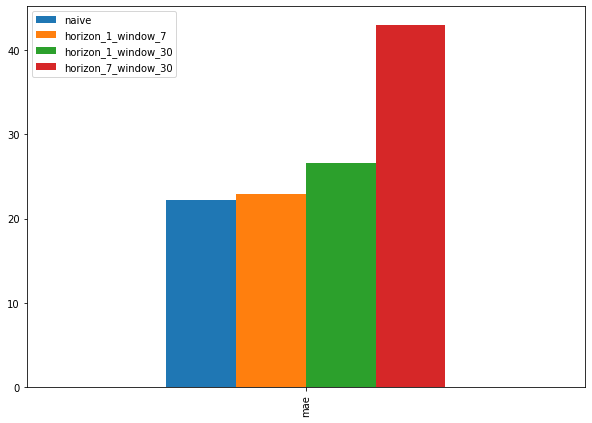

In [98]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

# Model 4: Conv1D

In [99]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [102]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=7, horizon=1)
len(full_windows), len(full_labels)

(4424, 4424)

In [103]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3539, 885, 3539, 885)

In [104]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [105]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[50.22022 ]
 [54.20921 ]
 [54.754753]
 [52.487488]
 [53.053055]
 [54.00901 ]
 [53.128128]]


In [106]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [107]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_18 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 4ms/step - loss: 23.0670


23.067047119140625

In [109]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

28/28 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1166.6759, 1172.6237, 1186.7047, 1178.9877, 1180.2753, 1190.8297,
       1194.7275, 1204.9211, 1208.8547, 1210.2495], dtype=float32)>

In [110]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 23.067043,
 'mse': 1110.3036,
 'rmse': 33.321217,
 'mape': 1.3605431,
 'mase': 1.0390767}

# Model 5: RNN (LSTM)

In [111]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [112]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

28/28 [==============================] - 0s 2ms/step - loss: 24.0923


24.09231185913086

In [113]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

28/28 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1166.1932, 1173.2966, 1183.2892, 1179.5052, 1180.3901, 1191.0024,
       1194.4165, 1201.6945, 1209.5366, 1210.5487], dtype=float32)>

In [114]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 24.092308,
 'mse': 1190.723,
 'rmse': 34.506855,
 'mape': 1.4172723,
 'mase': 1.0852607}